In [1]:
#|default_exp init

Background: We started with the goal of training an autoencoder, in Notebook 8, 
and realized we don't have the tools to make this work.
So we decided to create tools that will allow us to create a good Autoencoder, 
doing a fashion MNIST classifier.
We're gradually unwinding and we'll come back to creating an Autoencoder.

# Initialization

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init

from fastcore.test import test_close
from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

import logging
logging.disable(logging.WARNING)

In [5]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
set_seed()

Goal: get fashion MNIST accuracy of 90%+, (below 10% error).
3-4% error is SOTA, per [papers with code](https://paperswithcode.com/sota/image-classification-on-fashion-mnist).
*Without using any architectural changes, no resNets, etc.*

In [4]:
from datasets import load_dataset,load_dataset_builder
name = "fashion_mnist"
xl,yl = load_dataset_builder(name).info.features
num_classes=len(load_dataset_builder(name).info.features["label"].names)
dsd = load_dataset(name)
xl, yl, num_classes

('image', 'label', 10)

In [7]:
DataLoaders.from_dd?

Signature: DataLoaders.from_dd(dd, batch_size, as_tuple=True, **kwargs)
Docstring: <no docstring>
File:      ~/Downloads/GitHub/F22G/nbs/miniai/datasets.py
Type:      method

In [9]:
dsd = load_dataset(name)
@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(dd=tds, batch_size=1024, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 1, 28, 28]), tensor([1, 8, 6, 3, 6, 7, 0, 0, 2, 7]))

`get_model()` below is a simple "no-thinking" model.
First convolution is taking a (28x28?) by 1 channel input.
We compress it first to have 8 channels output (for the convolution), 
and then doubled the channels repeatedely to 16, 32, and 64.
The last `conv` is without activation so we get the 10 digits. 
`get_model()` will be "compessing" the images to 14x14, 7x7, 4x4, 2x2 and then 1x1.
NB: No thought at all behind this architecture, just pure convolutional, with necessary `Flatten` to get rid of the unit axes.

In [10]:
def get_model():
    return nn.Sequential(conv(1 ,8), conv(8 ,16), conv(16,32), conv(32,64),
                         conv(64,10, act=False), nn.Flatten()).to(def_device)

Q: why do we double the number of filters in successive convolutions?
A: because these are stride-2 convolutions, which reduce the grid size by a factor of 4. 
By doubling the channels, the total number of activations decreases by a factor of 2, forcing the model to intelligently compress information. This balance between reducing grid size (decreasing compute) and increasing channels (increasing compute) 
aims to maintain a consistent amount of computation while providing a compression challenge for the model.
<br>
Giving the model the same number of units or activations throughout wouldn't challenge it to learn as much. 
Instead, it's a balance between computational capacity and information compression, forcing the model to learn efficiently.

We're running an `LRfinder` for this simple model. However, the model performed so poorly that the LRfinder results were unclear. 
To fix this, JH introduced a multiplier `gamma` to make the learning rate increase more gradual, allowing us to extract useful insights.

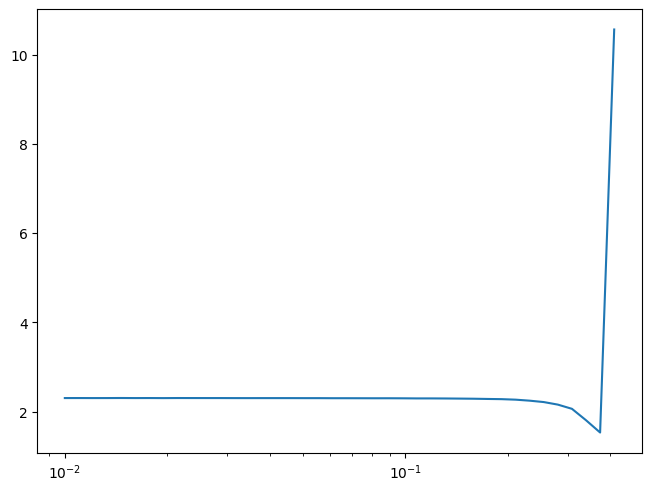

In [11]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

Add callbacks `cbs` for accuracy `metrics` and activation statistics `astat`, and also a Progress bar plot.

In [12]:
from torchmetrics.classification import MulticlassAccuracy
#from torchmetrics.aggregation import MeanMetric as Mean

metrics = MetricsCB(accuracy=MulticlassAccuracy(num_classes=num_classes))
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]

tried using a learning rate of 0.2 (after trying different values, .2 seems about the highest
we can get up to) 

In [13]:
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

It starts training and then we "lose it".

accuracy,loss,epoch,train
0.142,2.278,0,train
0.101,2.300,0,eval


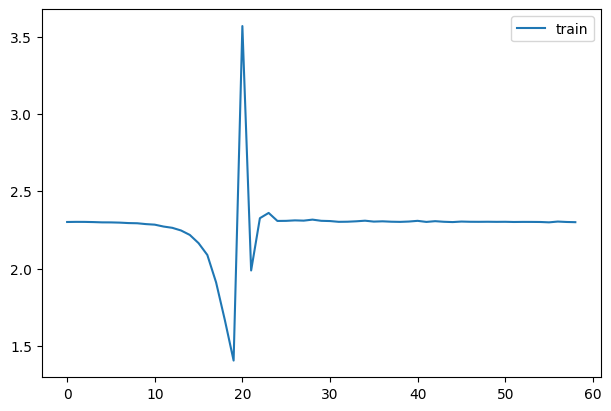

In [14]:
learn.fit(1)

In the colorful Dimension plot `color_dim()` we get activations crashing.

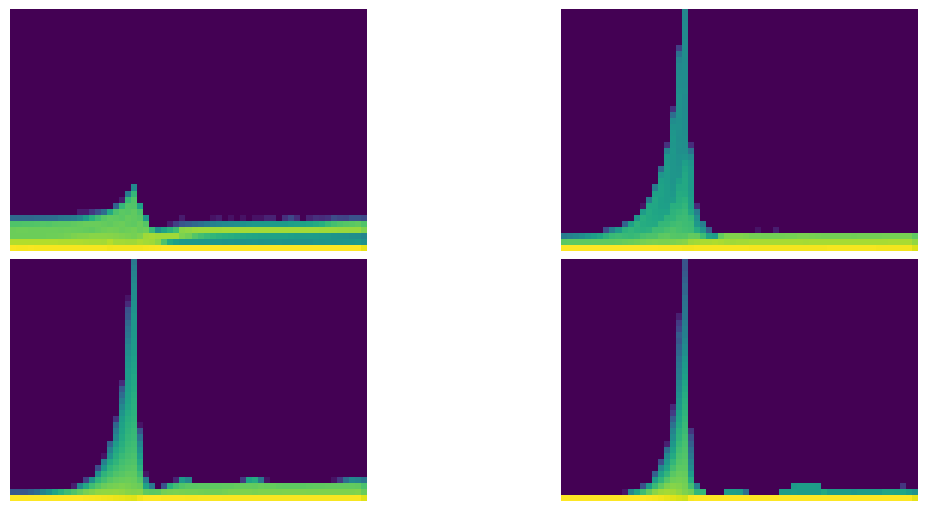

In [15]:
astats.color_dim()

`plot_stats()` shows the key problem:
We don't have 0 mean 1 standard deviation layers at the start, so we certainly don't keep them throughout.

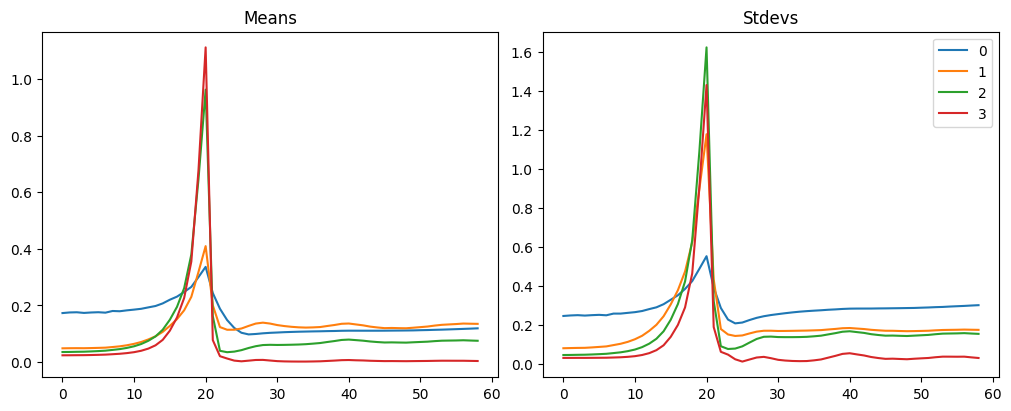

In [16]:
astats.plot_stats()

### Cleaning up GPU memory

Using Jupyter notebooks we can run out of GPU memory for many reasons:
1. Jupyter stores the results of previous cell evaluations.  
If we type `_` it returns the last thing evaluated, and more `_`s to go backwards in time.
To get the output of a specific cell, e.g., for `Out[16]:` use `_16`. 
The output shown (e.g., a big CUDA tensor), is kept in GPU memory.
When running out of GPU memory we can clean that GPU memory.
JH found such a function in the IPython source, copied important bits to `clean_ipython_hist()`

In [21]:
#|export
def clean_ipython_hist():
    """
    Clears the IPython (or Jupyter) input history and internal references
    to the last executed code cells (_i, _ii, _iii, etc.).
    Useful for resetting the interactive state in notebooks.
    """
    # Exit early if not running inside IPython
    if 'get_ipython' not in globals(): return

    ip = get_ipython()              # Get the current IPython shell
    user_ns = ip.user_ns            # The user namespace (where variables live)

    # Flush any pending display output
    ip.displayhook.flush()

    # Determine how many code inputs have been recorded
    prompt_count = ip.displayhook.prompt_count + 1

    # Remove stored variables like _i1, _i2, ..., _iN from the user namespace
    for n in range(1, prompt_count):
        user_ns.pop(f'_i{n}', None)

    # Reset global last input variables
    user_ns.update({'_i': '', '_ii': '', '_iii': ''})

    # Clear internal history in the IPython history manager
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * prompt_count
    hm.input_hist_raw[:]    = [''] * prompt_count

    # Reset additional internal history variables
    hm._i = hm._ii = hm._iii = hm._i00 = ''

After a CUDA error, Python stores the exception object, which can keep previously allocated tensors in memory. 
The `clean_tb()` function clears this traceback, freeing up memory. 
This is crucial when dealing with CUDA out-of-memory errors (OOME), as re-running code can still cause issues due to lingering allocations in the traceback.

In [22]:
#|export
import sys
import traceback

def clean_tb():
    """
    Clears the last exception traceback information stored in the `sys` module.

    This is useful in interactive environments (e.g., IPython or Jupyter)
    to prevent stale traceback frames from being kept in memory, which can
    interfere with debugging tools or memory profiling.
    """
    # If the last traceback exists, clear its internal frame references
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')

    # Remove stored exception type and value (if they exist)
    if hasattr(sys, 'last_type'):
        delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'):
        delattr(sys, 'last_value')


After a CUDA OOME, call `clean_mem()` to clean the Traceback, Jupiter history, garbage collect, and empty the Cuda cache.
This results in a *totally clean* GPU, and avoids the need to restart the notebook .

In [17]:
#|export
import gc
import torch

def clean_mem():
    """
    Frees up Python and GPU memory in an interactive session:
    - Clears traceback and input history (if in IPython)
    - Runs garbage collection
    - Frees GPU memory on MPS or CUDA devices
    """
    clean_tb()                # Clear last exception's traceback
    clean_ipython_hist()      # Clear _i/_ii/_iii and IPython history
    gc.collect()              # Run garbage collection

    # Determine active device
    device = (
        'mps'  if torch.backends.mps.is_available() else
        'cuda' if torch.cuda.is_available() else
        'cpu'
    )

    # Release cached GPU memory (if applicable)
    if device == 'mps':  torch.mps.empty_cache()
    elif device == 'cuda': torch.cuda.empty_cache()

## Glorot/Xavier init - Adressing the vanishing and exploding gradients problem.

### The vanishing and exploding gradients problem.
A Deep Learning Neural Net (DLNN) takes an input and puts it through many Matrix multiplications,
(and activation functions that don't change the argument here).
Imagine we start with some 50x50 DLNN, that takes the previous input and does matrix multiplied by some (initially) random weights. 

In [18]:
x = torch.randn(200, 100)
for i in range(50): x = x @ torch.randn(100,100)
x[0:5,0:5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

After 50 times of multiplying matrices the result is `nan`s everywhere. 
Was the scale of the matrix was too big, and we need to try smaller weights? 
Too small weights has the opposite problem, the scale of the activations will go from 1 to 0.1, and after 50 layers, zeros everywhere:

In [19]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100,100) * 0.01)
x[0:5,0:5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

The issue isn't NaNs (zeros), but extremely large or small numbers that exceed the computer's handling capacity due to limited precision in floating-point representation, which decreases as numbers move away from zero. 
To solve this, we need to properly scale our weight matrices to maintain a standard deviation ($\sigma$) of 1 and a mean ($\mu$) of 0 in the activations.

### Glorot or Xavier initialization
A technique designed to address the vanishing and exploding gradients problems in DLNNs, 
particularly when using sigmoid or hyperbolic tangent activation functions.
["Understanding the Difficulty of Training Deep Feedforward Neural Networks"](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)
proposes a weight initialization method to stabilize training by maintaining consistent gradient scales across layers. 
This is achieved through a controlled variance using a specific [uniform](https://en.wikipedia.org/wiki/Continuous_uniform_distribution) or 
[normal (Gaussian)](https://en.wikipedia.org/wiki/Normal_distribution) distribution, ensuring that the variance remains stable as signals propagate through the network.
The right scale for a given layer is $1/\sqrt{n_{in}}$, where $n_{in}$ represents the number of inputs.

Here we have $n_{in}=100$ inputs, $1/\sqrt{100}=0.1$.
If we start with random numbers and then we multiply by random numbers
times 0.1 (Glorot initialization), we end up with "reasonable" numbers.

In [21]:
x = torch.randn(200, 100)
for i in range(150): x = x @ (torch.randn(100,100) * 0.1)
x[0:5,0:5]

tensor([[-0.34, -0.32, -0.72,  0.24,  0.28],
        [-0.16, -0.15, -0.37,  0.11,  0.21],
        [ 0.28,  0.14,  0.36, -0.13, -0.10],
        [-0.03,  0.04,  0.09, -0.07,  0.15],
        [-0.86, -0.26, -0.81,  0.14,  0.76]])

## Statistical Background

### Variance and standard deviation

[*Variance*](https://en.wikipedia.org/wiki/Variance) is a statistical measure that quantifies the spread or dispersion of a set of values. 
Variance is the expected value of the squared deviation from the [mean](https://en.wikipedia.org/wiki/Mean) of a random variable
It provides insight into how much the values in a dataset *differ* from the mean of that dataset.
It is the **average of how far away each data point is from the mean**. 
If we take a a tensor `t` and just put some values in it, the *mean* ($\mu$) is the sum divided by the count, e.g. 6.25.

In [24]:
t = torch.tensor([1.,2.,4.,18])

μ = t.mean(); μ.item(), (t.sum()/len(t)).item()

(6.25, 6.25)

We're looking for a measure of variation or spread in the data. 
If data points are similar, they'll be close to the mean, but if they're widely spread, they'll be farther away from the mean, 
even if the mean itself remains the same.

In [27]:
(t-μ), (t-μ).mean().item()

(tensor([-5.25, -4.25, -2.25, 11.75]), 0.0)

To measure variation, we can subtract the mean from each value in our tensor. 
Since positive and negative differences cancel out, we can either square the differences, average them, and take the square root (standard deviation), or take the absolute differences and average them.

In [28]:
(t-μ).pow(2).mean().item(),  (t-μ).abs().mean().item()

(47.1875, 5.875)

But the first of these is now a totally different scale, since we squared. So let's undo that at the end with `sqrt`.

In [29]:
(t-μ).pow(2).mean().sqrt().item()

6.8693156242370605

They're still different. Why?
Note that we have one outlier (`18`). In the version where we square everything, the outlier makes the square much bigger than everything else.
$\sigma^2=(t-\mu)$.pow(2).mean() is the **variance**,  a measure of how spread out the data is, 
and is particularly sensitive to outliers.
When we take the sqrt $\sqrt{}$ of the variance, we get the [**standard deviation**](https://en.wikipedia.org/wiki/Standard_deviation), 
which is on the same scale as the original data, hence generally more interpretable. 
Since $\sqrt 1=1$, it doesn't matter which we use when talking about *unit variance* for initializing neural nets.
<br>
The standard deviation $\sigma$ represents if the data stays close to the mean or on the contrary gets values that are far away. 
It's computed by the following formula:
$$\sigma = \sqrt{\frac{1}{n}\left[(x_{0}-\mu)^{2} + (x_{1}-\mu)^{2} + \cdots + (x_{n-1}-\mu)^{2}\right]}$$
where $\mu$ is the mean.
Here $\mu = 0$, so it's just the square root of the mean of x squared.
<br>
$(t-\mu$)`.abs().mean()` is referred to as the [**mean absolute deviation MAD**](https://en.wikipedia.org/wiki/Average_absolute_deviation). 
It isn't used nearly as much as it deserves to be, because mathematicians don't like how awkward it is to work with. 
But that shouldn't stop us, because we have computers.
Mean Absolute Deviation (MAD) isn't used as much as standard deviation due to:
- Mathematical properties: Standard deviation has nicer properties for calculations and derivations.
- Differentiability: Standard deviation is differentiable, while MAD is not at the mean.
- Statistical inference: Standard deviation is closely tied to normal distributions and statistical procedures.
- Computational convenience: Standard deviation is often easier to compute and update.

However, MAD is still useful for its robustness to outliers and intuitive interpretation.
<br>
NB:
Variance can be calculated using a shortcut: the mean of the squared data points minus the square of the mean. 
This method allows us to track just two things - the sum of the data and the sum of squares - making it more efficient than calculating differences from the mean, which requires two passes through the data.

In [37]:
(t-μ).pow(2).mean(), (t*t).mean() - (μ*μ)

(tensor(47.19), tensor(47.19))

To see why these are equal we need to work thru the algebra.
Taking the LaTeX from [Wikipedia](https://en.wikipedia.org/wiki/Variance):
$\operatorname{E}\left[X^2 \right] - \operatorname{E}[X]^2$

### [Covariance](https://en.wikipedia.org/wiki/Covariance)
Covariance is a statistical measure that quantifies the degree to which two random variables change together. 
If the variables tend to increase and decrease simultaneously, the covariance will be positive. 
If one variable tends to increase when the other decreases, the covariance will be negative. 
If the variables do not exhibit any consistent pattern of co-movement, the covariance will be close to zero.
<br>
Wikipedia defines covariance as: $\operatorname{cov}(X,Y) = \operatorname{E}{\big[(X - \operatorname{E}[X])(Y - \operatorname{E}[Y])\big]}$

Let's see that in code. So now we need two vectors. First `t` and `u` which is two times t with a bit of randomness using [randn_like](https://docs.pytorch.org/docs/stable/generated/torch.randn_like.html).

In [32]:
u = t*2
u *= torch.randn_like(t)/10+0.95
print(t,"\n", u)

tensor([ 1.,  2.,  4., 18.]) 
 tensor([ 2.01,  3.55,  8.27, 37.53])


Lets plot points (t, u), where t is on the  horizontal axis and u on the vertical axis.

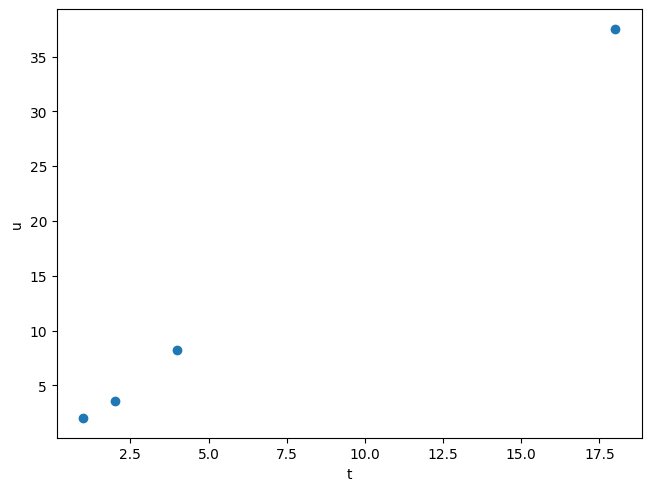

In [33]:
plt.xlabel("t")
plt.ylabel("u")
plt.scatter(t, u);

`u` and `t` are closely correlated, but not perfectly correlated.
[Covariance](https://en.wikipedia.org/wiki/Covariance) measures how two variables (`u` and `t`) vary together. 
It's calculated by subtracting the mean from each data point in both variables and multiplying the results together. 
This is similar to standard deviation, which can be thought of as covariance of a variable with itself.

In [34]:
prod = (t-t.mean())*(u-u.mean()); prod

tensor([ 56.87,  39.48,  10.29, 290.15])

then take the mean of that to give us the covariance between those two tensors.
It is quite a high number.

In [35]:
prod.mean()

tensor(99.20)

Lets compare it to two things that aren't very related, i.e., 
a random tensor`v` not related to `t`.

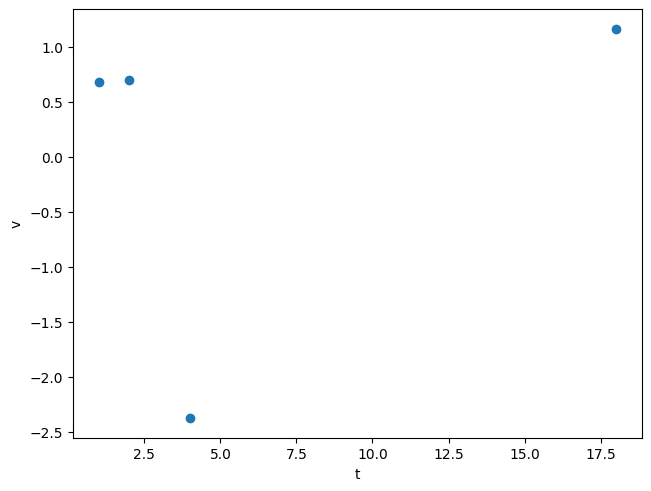

In [36]:
v = torch.randn_like(t)
plt.xlabel("t")
plt.ylabel("v")
plt.scatter(t, v);

We do the same thing, take the difference of `t` to its `mean` 
and `v` to its `mean`, and take the `mean` of that.
That's a very small number.
Covariance is basically telling us how related are these two tensors.

In [37]:
((t-t.mean())*(v-v.mean())).mean()

tensor(3.13)

We can think of variance as being covariance with itself.
We can change this mathematical version to this easier to calculate version which gives the same answer.
It's generally more conveniently defined: $\operatorname{E}\left[X Y\right] - \operatorname{E}\left[X\right] \operatorname{E}\left[Y\right]$

In [38]:
cov = (t*v).mean() - t.mean()*v.mean(); cov

tensor(3.13)

TODO: When looking at an equation (or typing it in $\LaTeX$), also type it in Python, calculate and plot some values. 
<br> The [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) 
is a correlation coefficient that measures linear correlation between two sets of data.
Given a pair of random variables $( X , Y )$ (for example, Height and Weight), the formula for ρ is:
$$\rho_{X,Y}= \frac{\operatorname{cov}(X,Y)}{\sigma_X \sigma_Y}$$

In [39]:
cov / (t.std() * v.std())   #Pearson coefficient for t and v

tensor(0.24)

In [40]:
def pearson_correlation_coefficient(X, Y):
    """
    Computes the Pearson correlation coefficient between two lists of numbers X and Y.
    Returns a float in [-1, 1] indicating linear correlation.
    """
    if len(X) != len(Y):
        raise ValueError("X and Y must be the same length.")
    if len(X) == 0:
        raise ValueError("X and Y must not be empty.")

    n = len(X)
    sum_X = sum(X)
    sum_Y = sum(Y)
    sum_XY = sum(x * y for x, y in zip(X, Y))
    sum_X2 = sum(x * x for x in X)
    sum_Y2 = sum(y * y for y in Y)

    num = n * sum_XY - sum_X * sum_Y
    denom_sq = (n * sum_X2 - sum_X**2) * (n * sum_Y2 - sum_Y**2)

    if denom_sq <= 0:
        return 0.0  # Avoid division by zero or sqrt of negative due to rounding

    return num / denom_sq**0.5

In [41]:
X = [10, 20, 30, 40, 50]
Y = [5, 10, 15, 20, 25]

r = pearson_correlation_coefficient(X, Y)
print(r)  # Output will be 1.0

1.0


### Xavier init derivation

When we do `y = a @ x`, the coefficients of `y` are defined by
$y_{i} = a_{i,0} x_{0} + a_{i,1} x_{1} + \cdots + a_{i,n-1} x_{n-1} = \sum_{k=0}^{n-1} a_{i,k} x_{k}$
<br>
or in pure python code: 
```python 
y[i] = sum([c*d for c,d in zip(a[i], x)])
```
or in numpy/pytorch code: 
```python 
y[i] = (a[i]*x).sum()
```

At the very beginning, our `x` vector has a $\mu$ roughly 0, and a $\sigma$ of roughly 1. (since we picked it that way).

In [43]:
x = torch.randn(1000)
x.mean(), x.std()

(tensor(-0.01), tensor(0.98))

If we go back to `y = a @ x` and assume that we chose weights for `a` that also have a mean of 0, we can compute the standard deviation of `y` quite easily. Since it's random, and we may fall on "bad numbers", we repeat the operation 100 times.

At the beginning our Vector has a  $\mu \approx 0$ and a $\sigma \approx 1$, 
as for earlier, via [`randn()`](https://www.geeksforgeeks.org/machine-learning/python-pytorch-randn-method/).
Let's create some random numbers and we can confirm they have a $\mu \approx 0$ and a $\sigma \approx 1$.
If we chose weights for `a` that'd have a $\mu = 0$ we can compute the $\sigma$ easily.
Let's do that a hundred times, create $x$ and something to multiply it by, $a$.
We do the matrix multiplication `y = a @ x` and we're going to get the `mean` and mean of the squares `sqr`.


In [47]:
mean,sqr = 0.,0.
nin = 200 # dimension
m = 100
for i in range(m):
    x = torch.randn(nin)
    a = torch.randn(512, nin)
    y = a @ x
    mean += y.mean().item()
    sqr  += y.pow(2).mean().item()
mean/m,sqr/m

(0.07106752455234527, 201.74089965820312)

Now `sqr/m` is very close to the `ni` dimension of our matrix. And that's no coincidence! 
When you compute y, you sum `ni` products of one element of `a` by one element of `x`. 
What is the $\mu$ and the $\sigma$ of such a product?
As long as the elements in `a` and the elements in `x` are independent, the $\mu \approx 0$ and the $\sigma \approx 1$. 
This can also be seen experimentally:

In [46]:
mean,sqr = 0.,0.
m = 100000
for i in range(m):
    x = torch.randn(1)
    a = torch.randn(1)
    y = a*x
    mean += y.item()
    sqr  += y.pow(2).item()
mean/m,sqr/m

(-0.002802686042623952, 1.0023050753556628)

Then we sum nin=100 of those things that have a mean of zero, and a mean of squares of 1, so we get something that has a mean of 0, and mean of square of `nin`, hence `math.sqrt(100)` is the magic number. If we scale the weights of the matrix and divide them by this `math.sqrt(100)`, it will give us a `y` of scale 1, and repeating the product has many times as we want won't overflow or vanish.

## Kaiming/He init

### Background

The problem is that Xavier's init doesn't work for us because we use
rectified linear units RELUs (not something that Xavier looked at).
Below a 200x100 matrix `x` and a 200 vector `y`.

In [48]:
x = torch.randn(200, 100)
y = torch.randn(200)

In [49]:
from math import sqrt

Let's create two weight matrices and two bias vectors.

In [50]:
w1 = torch.randn(100,50) / sqrt(100)
b1 = torch.zeros(50)
w2 = torch.randn(50,1) / sqrt(50)
b2 = torch.zeros(1)

`lin` is a linear layer function, and let's imagine this is the forward pass of our neural net.

In [51]:
def lin(x, w, b): return x @ w + b

We apply `lin` to the `x`s with our first set of weights `w1` and our first set of biases `b1`.

In [52]:
l1 = lin(x, w1, b1)
l1.mean(),l1.std()

(tensor(0.01), tensor(1.01))

The mean $\approx 0$ and standard deviation is $\approx 1$
(because we have 100 inputs and we divided it by $\sqrt 100$  per Xavier.
The 2nd  has 50 inputs and we divide by $\sqrt 50$ and so ought to work... but it is going to mess everything up by doing RELU.

In [53]:
def relu(x): return x.clamp_min(0.)

After we do a RELU we don't have as zero mean or a one standard deviation anymore.

In [54]:
l2 = relu(l1)
l2.mean(),l2.std()

(tensor(0.41), tensor(0.59))

A DNN with Xavier global initialization but with a RELU is gone to zero, 
as after a matrix multiply and a RELU the means and variances are going down (because a RELU squishes it).

In [55]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * 0.1))
x[0:5,0:5]

tensor([[    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00]])

In ["Delving Deep into Rectifiers: Surpassing Human-Level Performance"](https://arxiv.org/abs/1502.01852) Kaiming He et al. show that we should use the following scale instead: $\sqrt{2 / n_{in}}$, where $n_{in}$ is the number of inputs of our model.
<br>
Let's try it.
We've got 100 inputs, so we multiply it by $\sqrt{2 / 100}$ and we get non-zero numbers, even after going through 50 layers of depth.
(The Kaiming or He initialization.)

In [56]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * sqrt(2/100)))
x[0:5,0:5]

tensor([[0.00, 0.24, 0.49, 0.00, 0.92],
        [0.00, 0.36, 0.79, 0.00, 1.35],
        [0.16, 0.51, 1.69, 0.00, 2.24],
        [0.00, 0.19, 0.46, 0.00, 0.77],
        [0.01, 0.38, 1.09, 0.00, 1.58]])

### Applying an init function

Now that we know what initialization function to use for a deep neural network with a RELU activation function,
we use `apply` a method which all `nn.modules` have.
For example, let's apply `print()` to the name of the type.
It's going through and it's printing out all of the modules that are inside our model.

In [57]:
model = get_model()
model.apply(lambda m: print(type(m).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


NB: `model` (below) has modules inside modules, e.g., a `conv2d` in a `Sequential` in a `Sequential`.
But `model` did `apply` through all of them regardless of their depth.

In [58]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

So we can `apply` an `init` function, 
[`init.kaiming_normal_()`](https://docs.pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_),  
which fills input tensors with values using a Kaiming uniform distribution.
times $\sqrt{2 / n_{in}}$ for $n_{in}$ the number of inputs.
<br>
`_` at the end of a Pytorch method name means that it changes something *in place*.
It modifies the matrix `m.weight` (that was initialized with normally distributed random numbers) based on $\sqrt{2 / n_{in}}$.
<br>
We can't do that to a sequential layer or a flattened layer,
so we check that the module is a `conv` via `isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d))`.

In [59]:
def init_weights(m):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight)

and then  we can `model.apply` the `init_weights` function

In [60]:
model.apply(init_weights);

When we create our learner `MomentumLearner()`.

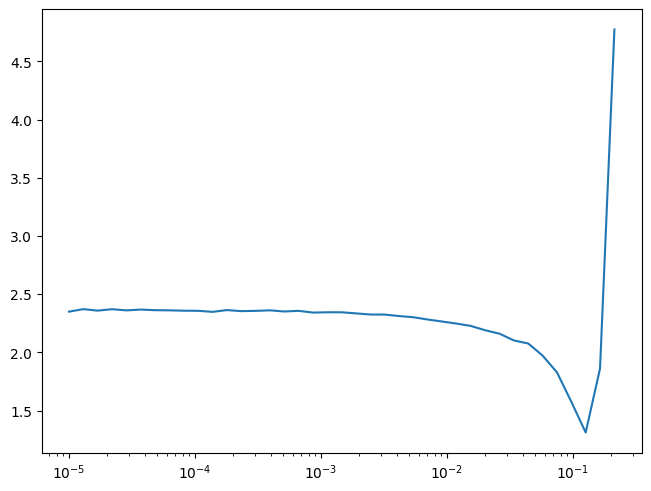

In [61]:
MomentumLearner(model, dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find()

After we get the model we `apply(init_weights)`, which 
also returns the model, so we can use it with the initialization applied.

In [62]:
set_seed()
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.420,1.707,0,train
0.726,0.726,0,eval
0.783,0.589,1,train
0.805,0.515,1,eval
0.823,0.480,2,train
0.820,0.483,2,eval


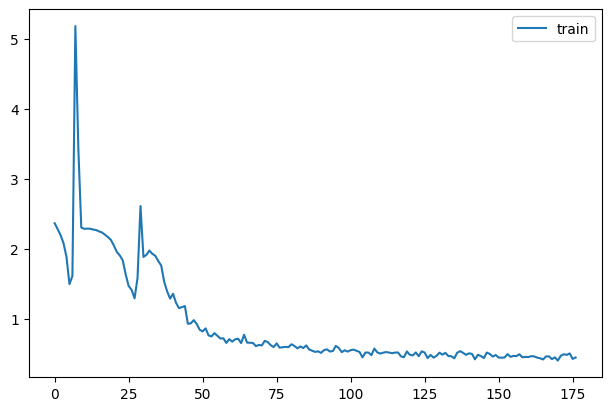

In [63]:
learn.fit(3)

Still not able to train well ...it's not great but it is actually starting to train.

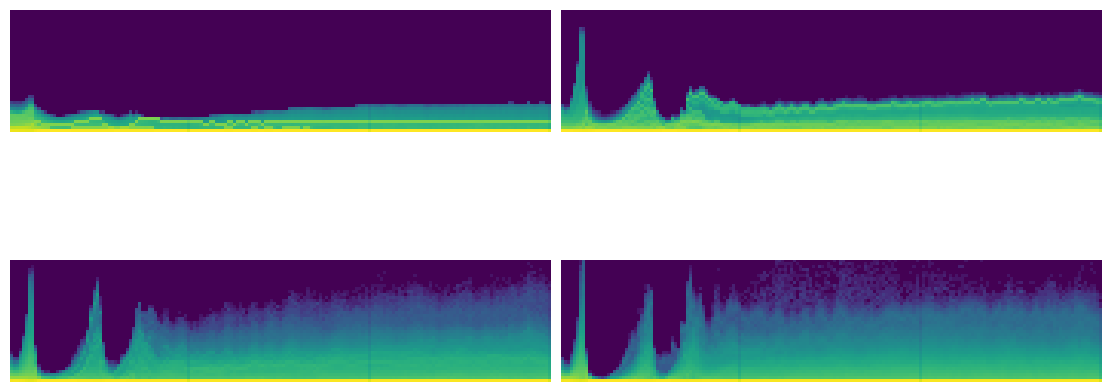

In [64]:
astats.color_dim()

we're getting these spikes...

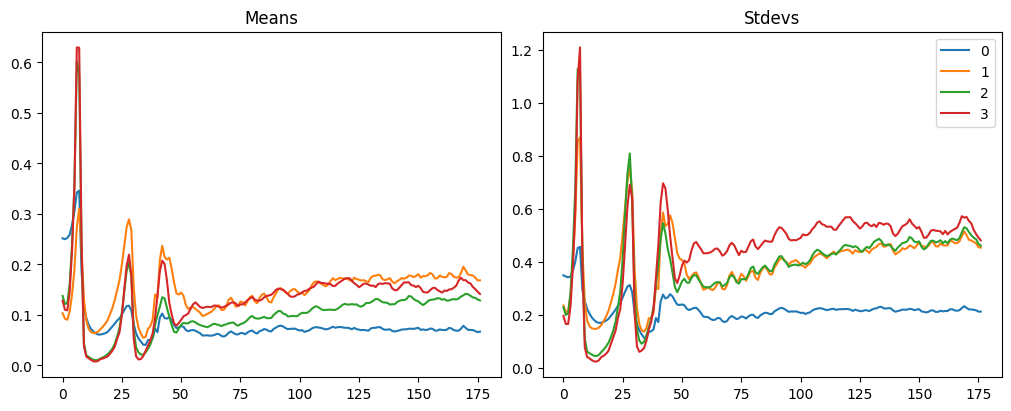

In [65]:
astats.plot_stats()

Why? Because we forgot to have a correctly normalized input Matrix, we never did anything to normalize our inputs....

## Input normalization

Lets get the first `xb` minibatch which has $\mu \approx .29,  \sigma \approx 0.35$. 
We didn't even start with a 0-1 input.
We need to modify our inputs so they have a $\mu \approx 0,  \sigma \approx 1$.

In [75]:
#xmean,xstd = xb.mean(),xb.std()
#xmean,xstd
xμ, xσ = xb.mean(),xb.std()
xμ, xσ

(tensor(0.29), tensor(0.35))

Let's create a `BatchTransformCB(Callback)`, and pass in a function `tfm` that's going to transform every batch.
In the `before_batch` we will set `learn.batch` to be equal to the function applied to the batch.
Note we don't need `self.learn.batch` on the right, 
(because it's one of the four things that we proxy down to the learner automatically)
but we do need it on the left hand side because it's only in the `getatrr`. 
We just leave it the same on both sides to avoid confusions.

In [67]:
#| export
class BatchTransformCB(Callback):
    def __init__(self, tfm, on_train=True, on_val=True): fc.store_attr()

    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_val and not learn.training):
            learn.batch = self.tfm(learn.batch)

Below `_norm()` subtracts the $\mu$ and divides by the $\sigma$.
A batch has an `X` (data) and a `Y` (label). 
It's the X part where we subtract the mean and divide by the standard deviation.
The new batch will have the normalized `X` and the same `Y` as before.
<br>
`norm` is an instance of the normalization of the `BatchTransformCB` callback, to pass it as an additional callback to the learner.

In [76]:
def _norm(b): return (b[0]-xμ)/xσ,b[1]
norm = BatchTransformCB(_norm)

accuracy,loss,epoch,train
0.549,1.379,0,train
0.771,0.595,0,eval
0.815,0.502,1,train
0.829,0.462,1,eval
0.844,0.420,2,train
0.850,0.406,2,eval


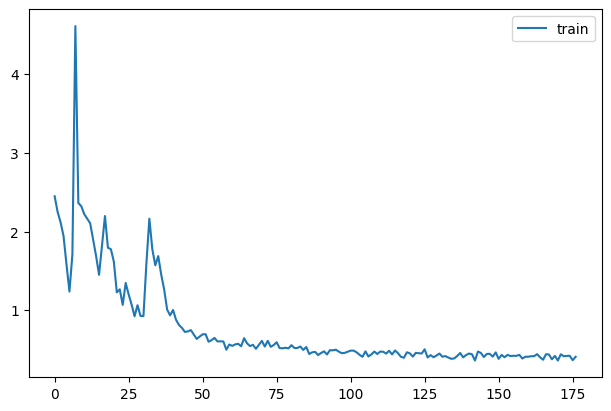

In [77]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs+[norm])
learn.fit(3)

Now looking a lot better.
We had to check that the input Matrix was 0 1, and all our weight matrices were 0 1.
Then (without any tricks) it was able to train, and improved accuracy.

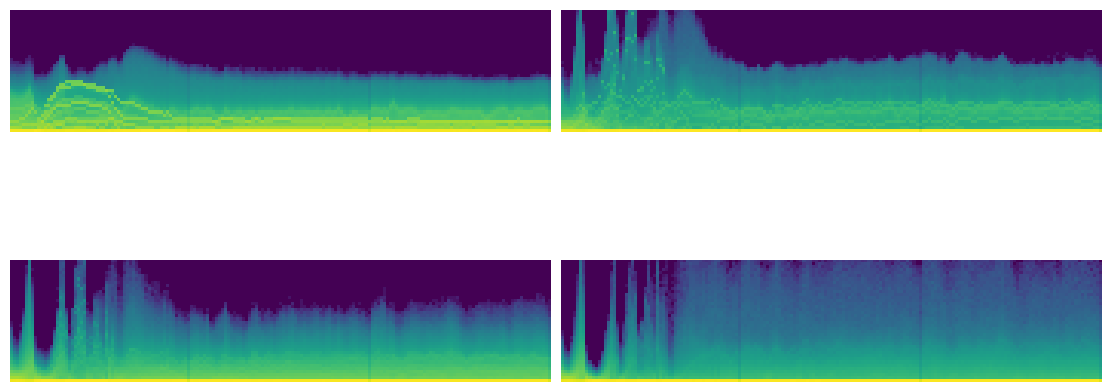

In [78]:
astats.color_dim()

The `color_dim` and `plot_stats` look "beautiful", but, still there's some Randomness, and we've got like seven or eight layers...
That Randomness you go through the layers by the last one it still gets a bit ugly,  it is bouncing around.
We can see that also in the means and standard deviations.
There are other reasons why this is happening (we'll see in a moment).
But this is the first time we've got a somewhat deep convolutional model to train.

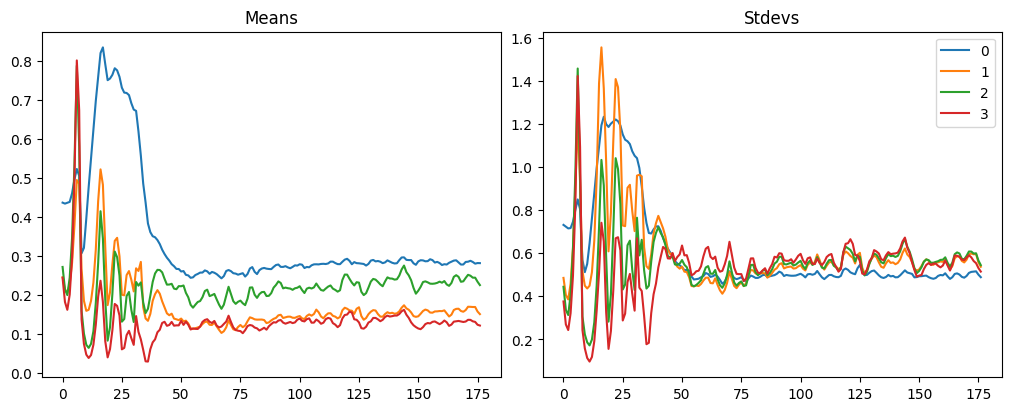

In [79]:
astats.plot_stats()

Milestone: We have created, from scratch, in a sequence of 11 notebooks a real convolutional neural network that is training properly.

#### with_transform
We don't have to use a callback for the batch normalization.
Alternatively, we could modify the input data with a `.with_transform` method from the Huggingface datasets Library.
We could modify our transform to just subtract the $\mu$ and divide by the $\sigma$ and then recreate our data loaders.

In [81]:
@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xμ)/xσ for o in b[xl]]
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size=1024, num_workers=4)
xb,yb = next(iter(dls.train))

Below batch `xb` got $\mu = 0, \sigma=1$, so we could also do it this way.
In general, stuff that needs to dynamically modify the batch can be done either in the data processing code or in a callback.
Both work well and you can see whichever one works best.

In [82]:
xb.mean(),xb.std()

(tensor(-0.00), tensor(1.00))

## General ReLU

The model is training, but the `plot_stats` don't show the desired $\mu = 0$ from the start. 
This is because the data passes through ReLU, which removes negative numbers, making a mean of 0 impossible (unless all numbers are zero). 
ReLU's nature conflicts with maintaining proper layer calibration in a neural network.
<br>
Leaky RELU Idea: Subtract something from the output of RELU (`-= self.sub`), to "pull" it down, 
so that the bottom of our value is underneath the x-axis (i.e. negatives), and get $\mu = 0$.
In a *Leaky RELU*, negatives are not truncated, but instead are decreased by some constant amount $\alpha$, 
typically $0.01 \leq \alpha \leq 0.1$.

`GeneralRelu` class provides a flexible activation function that can be adjusted to behave like a leaky ReLU, shifted horizontally, and clamped to a maximum value. 
By customizing these parameters, one can create variations of the ReLU activation function that may be better suited to specific tasks or architectures.

In [83]:
#| export
class GeneralRelu(nn.Module):
    """
    Generalized ReLU activation function, which includes options for leaky ReLU,
    horizontal shifting, and clamping to a maximum value.
    Attributes:
        leak (float, optional): Slope for negative values in leaky ReLU. If None, standard ReLU is used.
        sub (float, optional): Value to be subtracted from the activated tensor. Used to shift the activation function.
        maxv (float, optional): Maximum value to clamp the activated tensor to. Ensures no value exceeds this maximum.
    Example Usage:
        activation = GeneralRelu(leak=0.1, sub=0.5, maxv=5)
        x = activation(x)
    """

    def __init__(self, leak=None, sub=None, maxv=None):
        """
            leak (float, optional): Slope for leaky ReLU. If None, standard ReLU is used.
            sub (float, optional): Value to be subtracted from the activated tensor.
            maxv (float, optional): Maximum value to clamp the activated tensor to.
        """
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv

    def forward(self, x):
        """
        x (torch.Tensor): Input tensor.
        Returns:
            torch.Tensor: Activated tensor, after applying leaky/standard ReLU, subtraction, and clamping.
        """
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x


NB: a fun trick:
`GeneralRelu` has a maximum value `maxv`, and if it is set, then we `clamp_max_` the RELU to be no more than `maxv`, (e.g., 6),
so after that the line is flat, a nice way to avoid numbers getting too big.
**TODO:** a leaky maximum where at the top it is 10 times smaller, just exactly like the Leaky could be.
Ensure still getting 0-1 layers with the initialization*.

Lets see what that looks like, using `plot_func()` for plotting a function.

In [84]:
#| export
def plot_func(f, start=-5., end=5., steps=100):
    """
    Plots a given mathematical function 'f' over a specified range,
    with grid lines and both x and y axes. 
    Parameters:
        f (callable): The mathematical function to be plotted. It must accept a tensor `x` and return its corresponding values.
        start (float, optional): The starting value of the x-axis for plotting. Default is -5.
        end (float, optional): The ending value of the x-axis for plotting. Default is 5.
        steps (int, optional): The number of evenly spaced points between `start` and `end` to evaluate the function `f`. Default is 100.

    Example Usage:
        def my_func(x):
            return x**2 - 2*x + 1

        plot_func(my_func, start=-2, end=2, steps=50)
    """
    x = torch.linspace(start, end, steps)
    plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)


`GeneralRelu`, is where we do a leaky RELU, so it's not flat under zero,
but instead just less less sloped, and we also substract something from it.
<br>
Below plots `generalRELU` with a leakiness of 0.1 (so there's a 0.1 slope underneath the 0), and subtract 0.4.

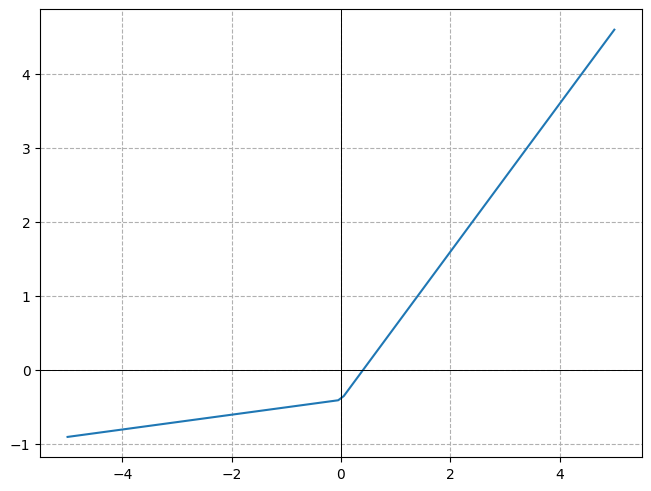

In [85]:
plot_func(GeneralRelu(leak=0.1, sub=0.4))

For $x>0$ it's a $y = x -0.4$ line.
When $x<0$ it is no longer flat (as RELU) but has a slope of .1.
If we find the right amount to subtract for each amount of leakiness we can make a $\mu = 0$.
JH found a particular combination (.1 and .4) which gives $\mu \approx 0$.

Let's define a new convolution function `conv` where we can change what activation function `act` is used.

In [86]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

Let's change `get_model` to allow it to take an activation function `act` which is passed into the layers.
Let's also make it easy to change the number of filters, passing in a list of the number of filters in each layer, `nfs`,
default it to the (earlier discussed) numbers in each layer `[1,8,16,32,64]`.
<br>
We go through a list comprehension `[conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]` 
creating `layers` with convolutions from the previous number of filters to the next number of filters.
And we'll pop that all into a `nn.Sequential` along with the last convolution to get 10 values, and a `nn.flatten` at the end.

In [87]:
from typing import List, Type, Optional
def get_model(act: Type[nn.Module] = nn.ReLU, nfs: Optional[List[int]] = None) -> nn.Sequential:
    """
    Creates a sequential convolutional neural network model.
    :param act: Activation function to use between convolutional layers.
    :param nfs: List of number of filters for each layer.
    """
    if nfs is None: nfs = [1, 8, 16, 32, 64]
    layers = [conv(nfs[i], nfs[i + 1], act=act) for i in range(len(nfs) - 1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None), nn.Flatten()).to(def_device)

Kaiming initialization only applies to layers that have a RELU activation function.
We have leaky RELU, subtracting a bit from it doesn't change things, but the fact that it is leaky does.
<br>
Pytorch's [nn.init.Kaiming_normal_](https://pytorch.org/docs/stable/nn.init.html?highlight=kaiming_normal#torch.nn.init.kaiming_normal_) 
has an adjustment for leaky RELU.
If we pass into the `Kaiming_normal_` the leaky value `a`, (float) – the negative slope of the rectifier used after this layer, 
then we get the correct initialization for a leaky RELU.
We need to change and it waits now to pass in the leakiness.

In [88]:
#| export
from typing import Union
import torch.nn.init as init

def init_weights(m: nn.Module, leaky: float = 0., method: str = "kaiming_normal") -> None:
    """
    Initializes the weights of the given module using the specified method.
    :param m: The module whose weights are to be initialized.
    :param leaky: The negative slope for leaky ReLU (used for Kaiming initialization).
    :param method: The initialization method to use ("kaiming_normal" or other supported methods).
    """
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
        if method == "kaiming_normal":  init.kaiming_normal_(m.weight, a=leaky)
        # Optionally, add more initialization methods here, e.g., Xavier initialization.
        
        # Initialize biases to zero if they exist
        if m.bias is not None: init.zeros_(m.bias)

`partial` below creates:
- `act_gr`, an activation function of `GeneralRelu` that has `leak=0.1` and `sub=0.4` as built-in parameters.
- `iw` an instance of  `init_weights` with `leaky=0.1`.


In [94]:
from torcheval.metrics import MulticlassAccuracy
#from torchmetrics.aggregation import MeanMetric as Mean

metrics = MetricsCB(accuracy=MulticlassAccuracy())

In [103]:
from torchmetrics.classification import MulticlassAccuracy

metrics = MetricsCB(accuracy=MulticlassAccuracy(num_classes=num_classes))
MulticlassAccuracy

torchmetrics.classification.accuracy.MulticlassAccuracy

In [104]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

We `get_model` using the `act_gr` function and `apply` the new initialization `iw`. 

In [105]:
model = get_model(act_gr).apply(iw)

We fit that and we're up to a accuracy $\approx$ 87%.

accuracy,loss,epoch,train
0.753,0.705,0,train
0.851,0.423,0,eval
0.866,0.364,1,train
0.869,0.365,1,eval
0.883,0.319,2,train
0.874,0.343,2,eval


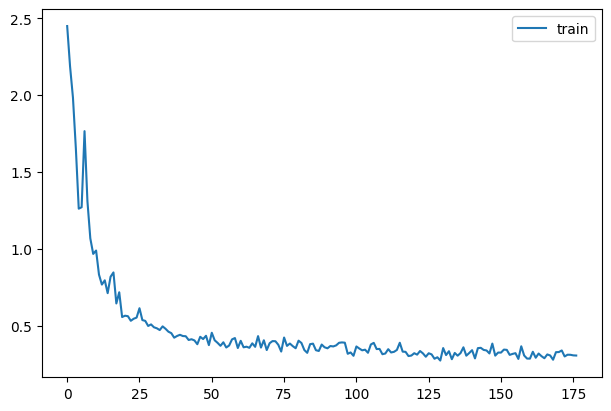

In [106]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

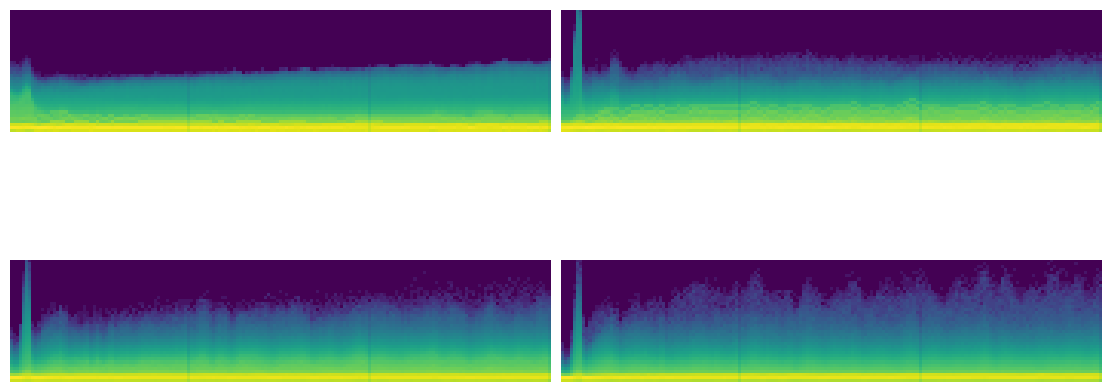

In [107]:
astats.color_dim()

We still got a little bit of a spike but it's almost smooth and flat.

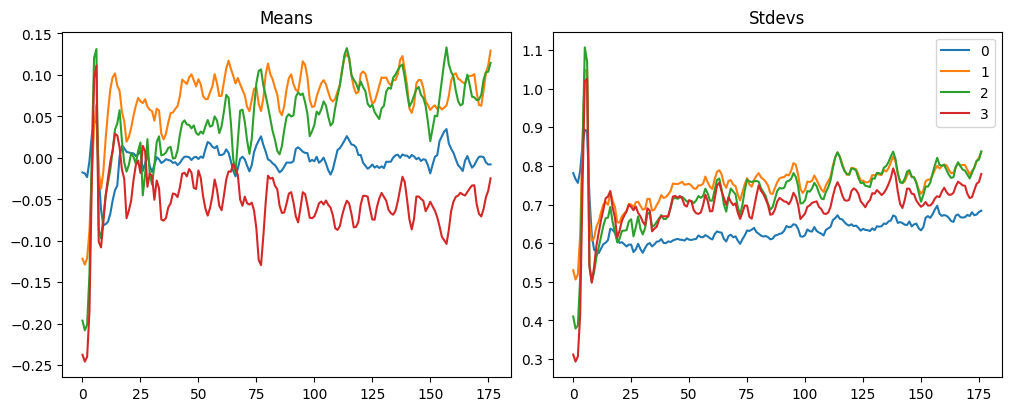

In [108]:
astats.plot_stats()

Our mean is starting at about $\mu \approx 0$, standard deviation is still a bit low, $\sigma \approx 0.8$.

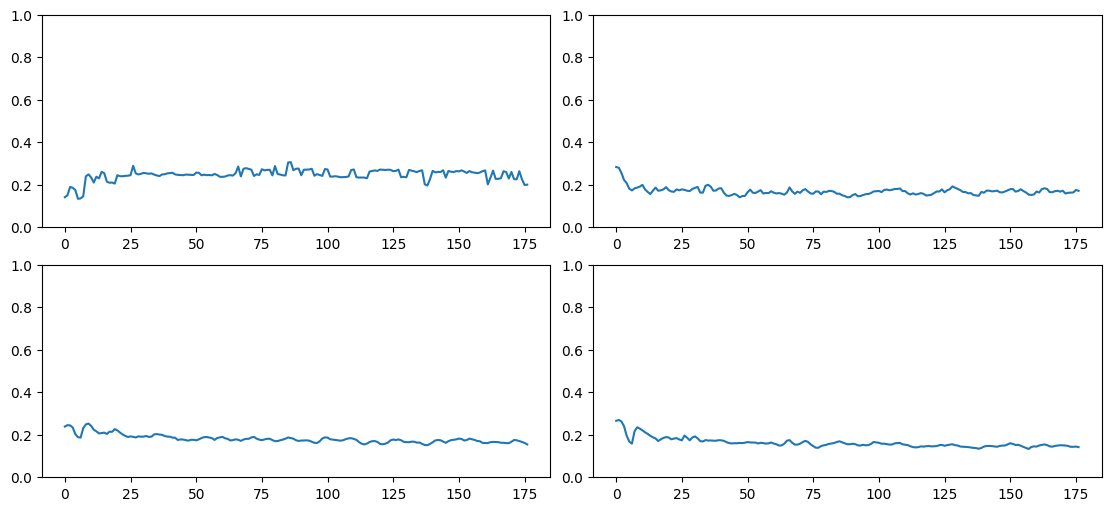

In [109]:
astats.dead_chart()

The percentage of dead units in each layer is small so finally very nice looking training graphs.
(The ratio of the very first smallest histogram bin to the rest of the bins), tells us what percentage (absolute numbers) have (near) zero or extremely small magnitudes. 

NB: We "invented" our own activation function to make this work.
This is critical and not mathematically difficult, not computationally difficult to see whether it's working.
Other Frameworks don't let you plot these kinds of things, so people don't know that they've messed up their initialization.

## LSUV

[All You Need is a Good Init](https://arxiv.org/pdf/1511.06422.pdf) introduces *Layer-wise Sequential Unit-Variance* (*LSUV*),
a general way of initializing any neural network correctly regardless of what activation functions.
For a given model:
1. Initialize weights using existing method (e.g. Gaussian), and set biases to 0.
2. For each pre-activation layer rescale the weights so that the standard deviation of its output is $\sigma =1$.
    1. Repeat until the correct $\mu$ and $\sigma$:
        1. If $\sigma$ is too big divide the weight matrix by a bit.
        2. If $\mu$ is too high subtract a bit off the weight Matrix.

We can implement this using hooks.
`_lsuv_stats` will grab the `mean` ($\mu$) and the `std` ($\sigma$) of the activations of a layer.
In `lsuv_init` we create a Hook `h` with `_lsuv_stats`. 
After we've run that (`_lsuv_stats`)  hook to find out the `mean` and `std` of the layer,
we will go through and run the `model`, get the `std` and `mean`.
If $\sigma \neq 1$, see if $\mu \neq 0$ (to an $\epsilon$ approximation, e.g., $1e^{-3}$).
We will subtract $\mu$ from the `bias`, and divide the weight matrix by $\sigma$. 
Repeat that until we get a $\sigma \approx 1 , \mu \approx 0$. 

In [124]:
#| export
def _lsuv_stats(hook, mod, inp, outp):
    acts = to_cpu(outp)
    hook.μ = acts.mean()
    hook.σ = acts.std()

def lsuv_init(m, m_in, xb):
    h = Hook(m, _lsuv_stats)
    with torch.no_grad():
        while model(xb) is not None and (abs(h.σ-1)>1e-3 or abs(h.μ)>1e-3):
            m_in.bias -= h.μ
            m_in.weight.data /= h.σ
    h.remove()

By making that a hook, we will grab all the `relus` and all the `convs`.

In [117]:
model = get_model(act_gr)
relus = [o for o in model.modules() if isinstance(o, GeneralRelu)]
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]

Once we've got all the `relus` and all the `convs`, we can use zip to take a bunch of lists and create a list of the items:
the first items, the second items, the third items, and so forth.
Below goes through the zip of`relus` and `convs` and just print them in order.
<mark> We use zip a lot, so it's important.</mark>

In [118]:
for ms in zip(relus,convs): print(ms)

(GeneralRelu(), Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))


We `zip` in `ms` all the `relus` and the `convs` and call `lsuv_init` passing in those relus and convs.
We do that on the the batch `xb`, and we need to put `xb` on the correct device for our model.

In [125]:
for ms in zip(relus,convs): lsuv_init(*ms, xb.to(def_device))

Now have it ran almost instantly, it's made all the biases and weights correct, give us $\mu \approx 0, \sigma \approx 1$.
Now we train, and it works, and we didn't do any initialization other than call `lsuv_init`.
Similar accuracy as before. 

accuracy,loss,epoch,train
0.888,0.302,0,train
0.873,0.348,0,eval
0.894,0.285,1,train
0.875,0.347,1,eval
0.897,0.276,2,train
0.874,0.346,2,eval


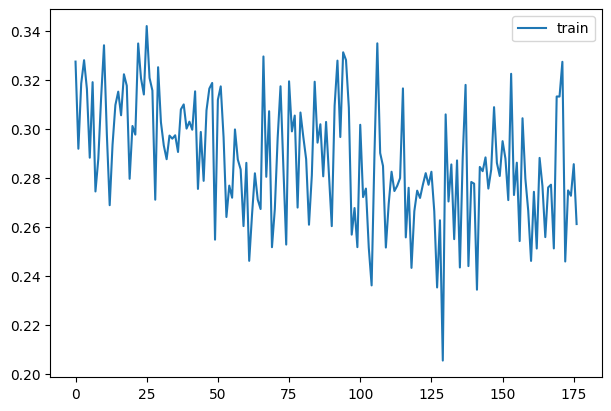

In [127]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

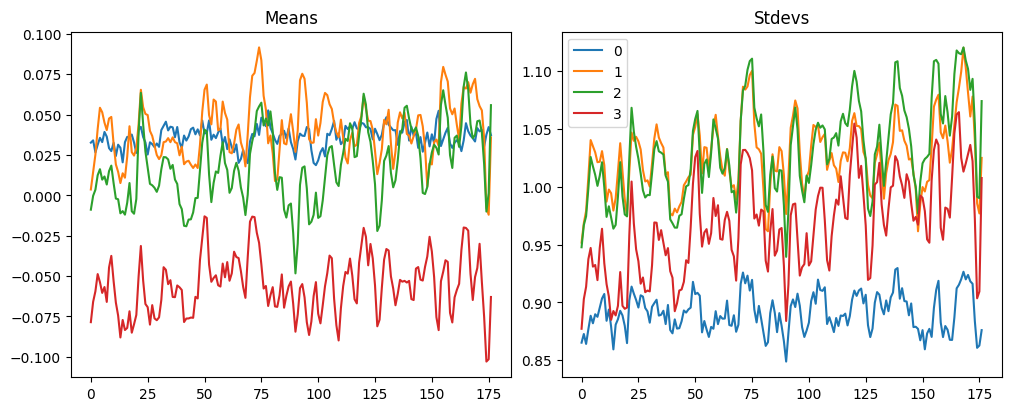

In [128]:
astats.plot_stats()

If we want to see that happening, we could say print $h.\mu, h.\sigma$ before and after. 
So it starts at the first layer, at a $\mu = -0.13$ and a $h.\sigma = 0.46$ and it kept doing the Divide, Subtract,
until eventually it got all the layers had a $\mu$ of 0 and a $\sigma$ of 1.

`lsuv` is mathematically convenient, as we don't have to spend any time thinking about 
a new activation function or we're using some activation function where nobody seems 
to have figured out the corrected initialization for it.
Just use `lsuv`.
It did require a little bit more fiddling with hooks to get it to work.
We haven't put this into a callback.
<br>
**TODO: Homework to see if we can come up with a callback that does lsuv initialization.**
Careful because if we ran fit multiple times it would initialize it each time.

## Batch Normalization

Something which is quite similar to lsuv is batch normalization.

Sergey Ioffe and Christian Szegedy released ["Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift"](https://arxiv.org/abs/1502.03167) in 2015, saying:

> Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization... We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs.

Their proposal is:

> Making normalization a part of the model architecture and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful about initialization.

One graph showed how many training steps are nneded to get to a certain accuracy on Imagenet,
and another graph showed with batchNorm, so much faster.
The idea of batchNorm is normalizing each layer's inputs before training.
But the distribution of each layer's inputs changes during training.
And that's a problem, so we end up having to decrease our learning rates,
and be very careful about parameter initialization.
That the layers inputs change during training they call *internal covariate shift*, (a confusing name).
Fix it by normalizing layer inputs during training, i.e., make the normalization a part of the model architecture, 
perform the normalization for each minibatch.

### LayerNorm   - start with [layer normalization](https://arxiv.org/abs/1607.06450), a simpler technique.

We can create a module that will be used as a Layer.
It has a `mult` for the multiplier, and `add` for the thing we're going to add.
We start by multiplying by 1 and adding 0, i.e., start by doing nothing.
The layer has a `forward` function, (recall by default we have NCHW), i.e., Batch by Channel by Height by Width.
We take the mean over the channel, height, and width, (1,2,3), i.e., find the mean activation for each input in the minibatch.
And we do the same thing for finding the variance.
Then we're going to normalize our data by subtracting the mean and dividing by the standard deviation.
<br>
We add a very small number `.eps` to the denominator,
in case the variance is zero or too small, to keep the number from exploding if we get a very small variance.
Adding $\epsilon$ to a divisor is common, and we should not assume that the defaults are correct.
Very often the defaults are too small for algorithms that use an $\epsilon$.

We are normalizing the input (ie the batch if it is the 1st layer).
But maybe we don't want it to be normalized, i.e., 
to have something other than unit variance and zero mean.
What we do is we then multiply it back by `self.mult` and add `self.add`.
`self.mult` was 1 and `self.add` zero, so at first that does nothing.
Because these are parameters, they are learnable, i.e., the SGD algorithm can change them.
Hence this might not be *normalizing* the inputs to the next layer,
because `self.mult` and `self.add` could be anything.
Layer normalization and batch normalization are *normalizing* for the initial layers.
We don't need `lsuv` if we have this in here because it's going to normalize it automatically.

But after a few batches it's not "normalizing".
Previously, how big are the numbers overall and how much variation do they have
was in every single number in the weight Matrix and in the bias vector.
But this way those have been turned into just 2 numbers, making training a lot easier.
So it can focus on those 2 numbers to change.
Something subtle is going on, because it's not just doing normalization (after the first few batches) 
because it can learn to create any distribution of outputs.

In [80]:
class LayerNorm(nn.Module):
    def __init__(self, dummy, ϵ=1e-5):
        super().__init__()
        self.ϵ = ϵ
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    def forward(self, x):
        μ = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-μ) / ((v+self.ϵ).sqrt())
        return x*self.mult + self.add

Lets change `conv` again (previously added an activation function `acct`), 
now allow to add normalization layers `norm` to the end.
Start by adding our `conv2d` to `layers` as usual.
Then if we are doing normalization we `append` the normalization layer `norm(nf))` with `nf` inputs.
`LayerNorm` doesn't care how many inputs, so we just ignore it.
But `BatchNorm` cares if you've got an activation function.
The `conv` layer is a `Sequential` bunch of `layers`.

In [81]:
#|export
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

In the model, we add layer normalization to every layer except for the last one (`nfs[-1]`).

In [82]:
#|export
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)

accuracy,loss,epoch,train
0.789,0.579,0,train
0.840,0.439,0,eval
0.866,0.368,1,train
0.866,0.371,1,eval
0.880,0.327,2,train
0.854,0.403,2,eval


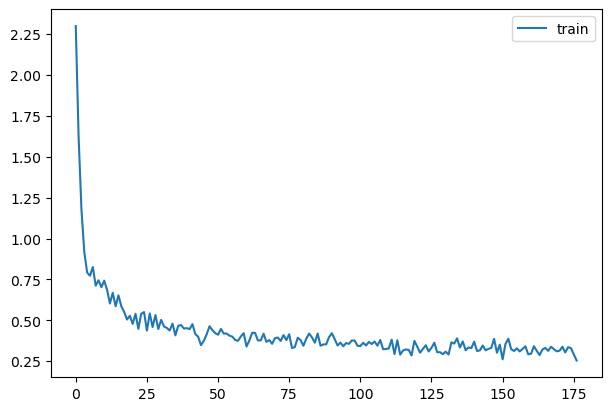

In [83]:
set_seed(42)
model = get_model(act_gr, norm=LayerNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

NB: Normalization layers do cause challenges in models.
At first BatchNorm was seen as a savior, (let us train deeper models quickly).
But its learnable parameters create complexity.
There is a tendency to get rid or reduce the use of these kinds of layers, 
so knowing how to initialize models correctly is becoming increasingly important.
They are still helpful but they're not a silver bullet.

### Lerp -Linear Interpolation
Formula: $\text{lerp}(a,b,t) = (1−t)⋅a + t⋅b$
`lerp` takes two tensors, $a, b$, vectors or matrices, and returns a weighted average of them using the last argument t.
For t=0.5 it take half of each number, i.e., the mean; For t=0.75, then is 0.75 times b plus 0.25 times a. 
Like a sliding scale, as the extremes ($t=0, t=1$) yield $a$ and $b$, and we can slide anywhere between them.

In [84]:
l1 = torch.lerp(tensor(5.0), tensor(15.0), tensor(0.5))
l2 = torch.lerp(tensor(5.0), tensor(15.0), tensor(0.75))
l3 = torch.lerp(tensor(5.0), tensor(15.0), tensor(0.))
l4 = torch.lerp(tensor(5.0), tensor(15.0), tensor(1.))
l5 = torch.lerp(tensor(5.0), tensor(15.0), tensor(0.95))
l1,l2,l3,l4,l5

(tensor(10.), tensor(12.50), tensor(5.), tensor(15.), tensor(14.50))

Like most Pytorch things we can move the first parameter,
and get the same result.

In [85]:
tensor(5.0).lerp(tensor(15.0), tensor(0.95))

tensor(14.50)

### BatchNorm

BatchNorm is a bit bigger than LayerNorm.
As before we have the `mult` and `add`  but now it's not just one number each,
because we're going to have *one for every channel*.
We take the mean ($\mu$) and the variance ($\sigma^2$) over the batch dimension and the height and width dimensions `(0,2,3)`.
We end with one ($\mu, \sigma^2$) per Channel.
As before we subtract them out, and divide them by the $\epsilon$ modified $\sigma^2$.
Then multiply by a vector of `mult` and add a vector of `add`s.
We have to pass in the number of filters, `nf`, because we have to know 
how many 1s and 0s we have in our initial `mult`s and `add`s.
The main difference is that we have one per Channel,
and that we're taking the average across all of the things in the batch.
(In LayerNorm we did it each thing in the batch had its own separate normalization).
<br>
We're doing an in-place lerp, replacing `self.means` with one minus momentum `mom` 
of `self.means` and plus `self.mom` times this particular minibatch `mean`.
It is doing momentum again with a `mom` of 0.1.
(NB: seems the opposite of what we expected, 0.9). 
A mom of 0.1 is saying that each minibatch `self.means` will be 0.1 
of this particular minibatch mean and 0.9 of the previous sequence.
That gives us an *exponentially weighted moving average*.
We do the same thing for variances.
That's only updated during `.training`, during inference we use the saved means and variances.
<br>
The `register_buffer`s saves the means and variances as part of the model.
This makes `BatchNorm` tricky, particularly with transfer learning.
A single "weird" minibatch shouldn't screw things, because we're averaging across the mini-batch it's also going to make things smoother.

In [86]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, ϵ=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.ϵ = mom,ϵ
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        μ = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(μ, self.mom)
        self.vars.lerp_ (v, self.mom)
        return μ,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): μ,v = self.update_stats(x)
        else: μ,v = self.means,self.vars
        x = (x-μ) / (v+self.ϵ).sqrt()
        return x*self.mults + self.adds

We train with `norm=BatchNorm`. 
JH got the LR up to 0.4 for the first time.
He was trying to push the LR and now able to double it, and it's training smoothly.

accuracy,loss,epoch,train
0.793,0.572,0,train
0.842,0.451,0,eval
0.873,0.345,1,train
0.864,0.364,1,eval
0.884,0.311,2,train
0.875,0.343,2,eval


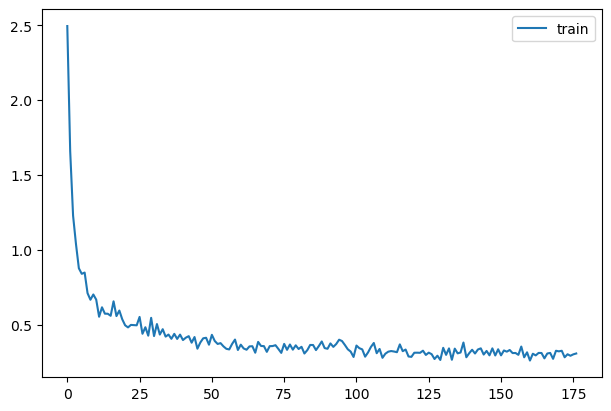

In [87]:
model = get_model(act_gr, norm=BatchNorm).apply(iw)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs)
learn.fit(3)

There are different types of layer-based normalization.
In addition to `LayerNorm` and `BatchNorm`, there's `InstanceNorm`,  `GroupNorm`,... 
Below picture from the [Group Normalization](https://arxiv.org/abs/1803.08494v3) paper explains what happens. 
They concatenated flattened HW into a single axis, since they can't draw 4D cubes.
In `BatchNorm`, the blue stuff is what we average over (across the batch and across the height and width)
and we end up with one normalization number per Channel.
`LayerNorm` averages over the channel and the height and the width,
and it has a separate one per item in the mini batch.
A bit subtle, as the `mult` `add` just had a single number for each.
`InstanceNorm` only averages across height and width so there's going to be a separate one 
for every channel and every element of the minibatch.
`GroupNorm` is like `InstanceNorm` but it arbitrarily groups a bunch of channels together,
(we decide how many groups), and averages over them.
`GroupNorm` is a bit slow, but avoids some of the challenges of the other methods, so it's worth trying it. 
<br>
`BatchNorm` has the additional momentum based statistics.
The use of momentum based statistics, to store things per Channel, what do you average over, etc. are somewhat independent choices.
We can make particular combinations of those which have been given particular names.

![Various norms](images/norms.png)

## Towards 90%...

Let's put the initialization methods all together. 
We've been using a batch size of 1024 for speed purposes.
If we lower it to 256 the model is going to see more minibatches, and that should improve performance.

In [88]:
dls = DataLoaders.from_dd(tds, batch_size=256, num_workers=4)

Lets use Pytorch's `nn.BatchNorm2d`, and the `MomentumLearner` will fit for 3 epochs, going a little bit more slowly now.

accuracy,loss,epoch,train
0.837,0.448,0,train
0.857,0.384,0,eval
0.881,0.322,1,train
0.874,0.346,1,eval
0.893,0.291,2,train
0.862,0.390,2,eval


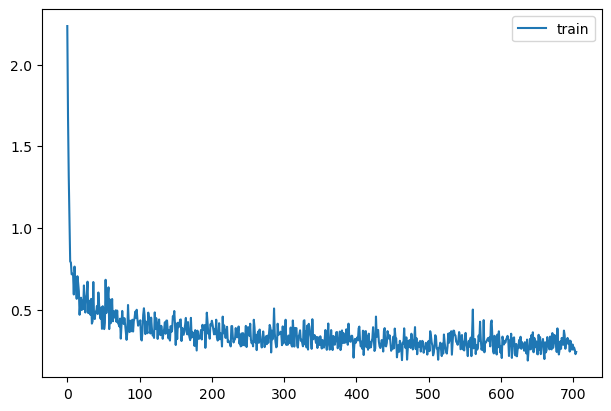

In [89]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

As it's getting close to a good answer, lets fine-tune the existing model by decreasing the `lr`  and train for a little bit longer.
We improved accuracy after 3 epochs thanks to using a smaller minibatch size.
With a smaller minibatch size we have to decrease the learning rate.
We could still use 0.2 and after one more epoch we've got close to our .90 goal. 

accuracy,loss,epoch,train
0.913,0.236,0,train
0.894,0.286,0,eval
0.918,0.222,1,train
0.896,0.285,1,eval


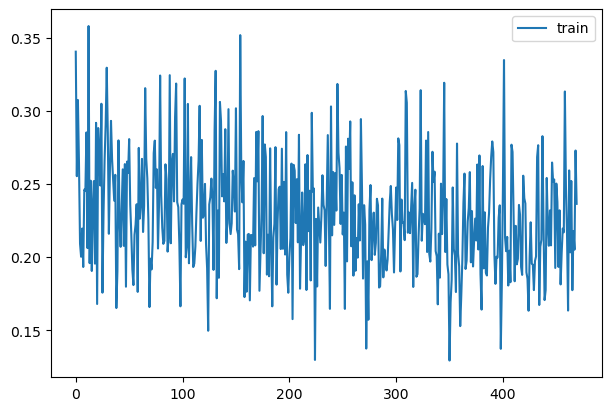

In [90]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.05, cbs=cbs)
learn.fit(2)

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()